In [1]:
# Importing the pandas library, which is used for data manipulation and analysis
import pandas as pd

# Importing the numpy library, which is used for numerical operations and handling arrays
import numpy as np

# Importing seaborn for data visualization, particularly statistical plots
import seaborn as sns

# Importing matplotlib for general plotting and graphing, commonly used for creating static visualizations
import matplotlib.pyplot as plt

# Importing xml.etree.ElementTree for parsing and creating XML data
import xml.etree.ElementTree as ET


In [2]:
# Reading the housing data from a CSV file named 'housing_prices.csv'
# The delimiter for separating values is a comma, and the quote character is double quotes
housing_data = pd.read_csv("housing_prices.csv", delimiter=',', quotechar='"')

# Reading the population data from a CSV file named 'population_data.csv'
# The delimiter for separating values is a comma, and the quote character is double quotes
population_data = pd.read_csv("population_data.csv", delimiter=',', quotechar='"')

In [3]:
# Defining the name of the country to filter the population data
country_name = "United Kingdom"

# Filtering the population data to get the row(s) where the "Country Name" matches the defined country_name
country_population = population_data[population_data["Country Name"] == country_name]


In [4]:
# Selecting specific columns from the filtered 'country_population' DataFrame:
# - "Country Name" and "Country Code" columns are kept
# - Adding columns for years 2013 to 2023 dynamically by iterating through the range of years
country_population = country_population.loc[:, ["Country Name", "Country Code"] + [str(year) for year in range(2013, 2024)]]

In [5]:

# Parsing the XML file located at 'file_path' and storing it as an ElementTree object
tree = ET.parse("land_of_countries.xml")

# Getting the root of the XML tree to begin traversing the XML structure
root = tree.getroot()

# Defining a function to extract the value for the United Kingdom in 2013
# The function iterates through each 'record' in the XML to find the specific country and year
def extract_uk_value(root):
    # Iterating through each 'record' element in the XML
    for record in root.findall(".//record"):
        # Extracting the 'Country or Area' and 'Year' values from the current record
        country = record.find(".//field[@name='Country or Area']").text
        year = record.find(".//field[@name='Year']").text
        
        # Checking if the current record matches the United Kingdom and the year 2013
        if country == "United Kingdom" and year == "2013":
            # Extracting the value from the 'Value' field and returning it
            value = record.find(".//field[@name='Value']").text
            return value
    # Returning None if no matching record is found
    return None

# Calling the function to get the value for the United Kingdom in 2013
uk_value = extract_uk_value(root)

# Printing the extracted value for the United Kingdom in 2013
print(f"The value for the United Kingdom in 2013 is: {uk_value}")


The value for the United Kingdom in 2013 is: 241930


In [6]:
# Reshaping the 'country_population' DataFrame using melt:
# - 'Country Name' and 'Country Code' are kept as identifier variables (id_vars)
# - The 'Year' is used as a new column representing each year from 2013 to 2023
# - 'Population' values for each year are now stored in a column called 'Population'
uk_population = country_population.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")

# Ensuring the 'Population' column is numeric:
# - Any non-numeric values will be converted to NaN using 'errors='coerce''
uk_population["Population"] = pd.to_numeric(uk_population["Population"], errors='coerce')

# Ensuring 'land_area' is numeric as well (assuming land_area is a separate variable)
# - If 'uk_value' represents land_area, converting it to a numeric type
land_area = pd.to_numeric(uk_value, errors='coerce')

# Calculating the population density:
# - Dividing the population for each year by the land area to get population density
uk_population["Population Density"] = uk_population["Population"] / land_area

# Handling potential NaN values in 'Population Density':
# - If there are any NaN values, replace them with 0
uk_population["Population Density"].fillna(0, inplace=True)

# Checking the result by printing the reshaped DataFrame
print(uk_population)

      Country Name Country Code  Year  Population  Population Density
0   United Kingdom          GBR  2013  64128273.0          265.069537
1   United Kingdom          GBR  2014  64602298.0          267.028884
2   United Kingdom          GBR  2015  65116219.0          269.153139
3   United Kingdom          GBR  2016  65611593.0          271.200732
4   United Kingdom          GBR  2017  66058859.0          273.049473
5   United Kingdom          GBR  2018  66460344.0          274.708982
6   United Kingdom          GBR  2019  66836327.0          276.263080
7   United Kingdom          GBR  2020  67081234.0          277.275385
8   United Kingdom          GBR  2021  67026292.0          277.048287
9   United Kingdom          GBR  2022  67791000.0          280.209151
10  United Kingdom          GBR  2023  68350000.0          282.519737


In [7]:
# Converting the 'Date' column in the 'housing_data' DataFrame to a datetime format
# This ensures that the 'Date' column is properly recognized as a date type for time-based analysis
housing_data['Date'] = pd.to_datetime(housing_data['Date'])

In [8]:
# Filtering the 'housing_data' DataFrame to select rows where:
# - The month is August (month == 8)
# - The day is the 1st (day == 1)
# - The year is between 2013 and 2023 (inclusive)
filtered_data = housing_data[(housing_data['Date'].dt.month == 8) & (housing_data['Date'].dt.day == 1) & (housing_data['Date'].dt.year >= 2013) & (housing_data['Date'].dt.year <= 2023)]
# Sorting the 'filtered_data' DataFrame by the 'Date' column in ascending order
# This ensures that the data is ordered chronologically
filtered_data = filtered_data.sort_values(by='Date')

In [9]:
# Selecting only the 'Date' and 'Price (All)' columns from 'filtered_data' for the 'housing_data' DataFrame
housing_data = filtered_data[["Date", "Price (All)"]]

# Extracting the year from the 'Date' column and creating a new 'Year' column in the 'housing_data' DataFrame
# The 'Date' column is first converted to datetime format, then the year is extracted
housing_data["Year"] = pd.to_datetime(housing_data["Date"]).dt.year

# Dropping the 'Date' column from the 'housing_data' DataFrame, as the 'Year' column now contains the relevant information
housing_data = housing_data.drop(columns=["Date"])

/var/folders/r9/hs7j8x6s2_qczl2vyt_y375w0000gn/T/ipykernel_8298/1733110138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_data["Year"] = pd.to_datetime(housing_data["Date"]).dt.year


In [10]:
# Ensuring the 'Year' column in both DataFrames is of type int:
# - Convert the 'Year' column to numeric, coercing errors to NaN and downcasting to integer
housing_data["Year"] = pd.to_numeric(housing_data["Year"], errors="coerce", downcast="integer")
uk_population["Year"] = pd.to_numeric(uk_population["Year"], errors="coerce", downcast="integer")

# Merging the two DataFrames (housing_data and uk_population) on the 'Year' column:
# - The merge is performed with an inner join, keeping only rows with matching years in both DataFrames
merged_data = pd.merge(housing_data, uk_population, on="Year", how="inner")

# Grouping the merged DataFrame by 'Year' and calculating the mean for 'Price (All)' and 'Population Density':
# - The groupby operation calculates the average values for both 'Price (All)' and 'Population Density' for each year
merged_data_grouped = merged_data.groupby("Year")[["Price (All)", "Population Density"]].mean().reset_index()

# Checking the result by printing the grouped DataFrame
print(merged_data_grouped)


    Year  Price (All)  Population Density
0   2013     170918.0          265.069537
1   2014     188810.0          267.028884
2   2015     195733.0          269.153139
3   2016     206346.0          271.200732
4   2017     211672.0          273.049473
5   2018     216103.0          274.708982
6   2019     216805.0          276.263080
7   2020     224337.0          277.275385
8   2021     247535.0          277.048287
9   2022     273135.0          280.209151
10  2023     260181.0          282.519737


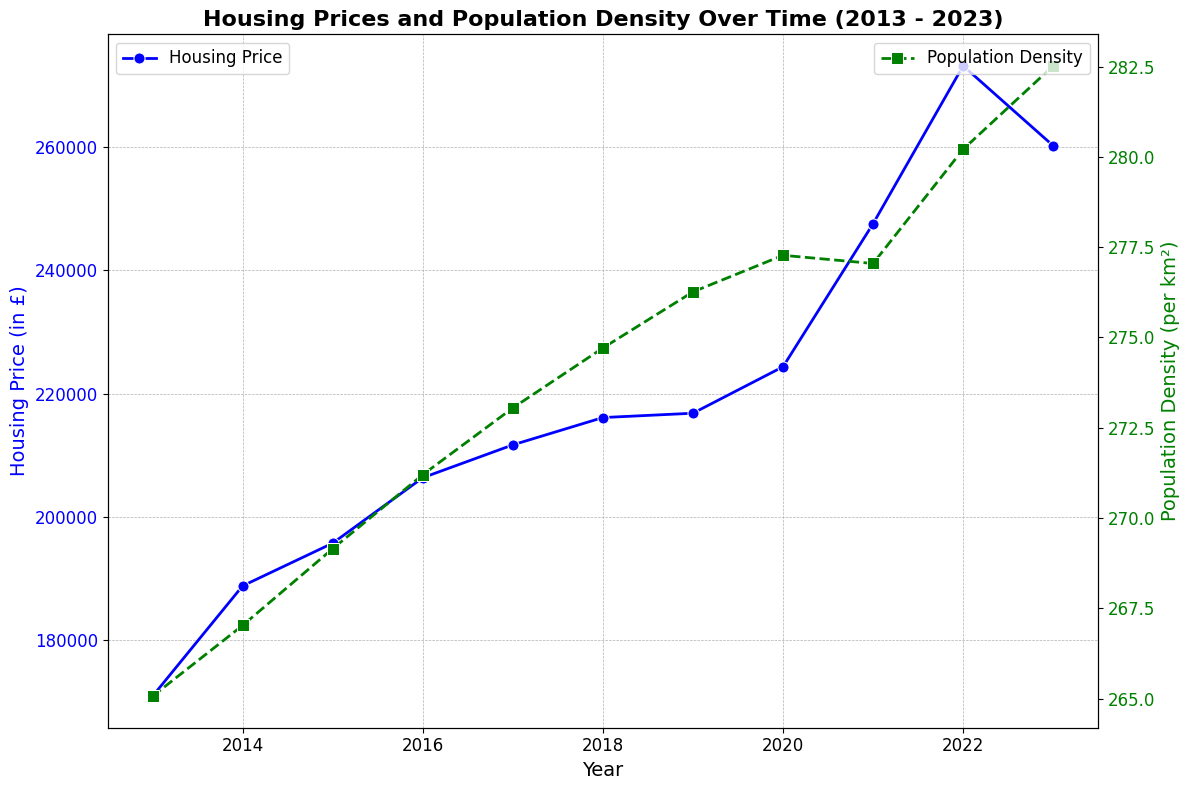

In [11]:
# Creating a figure and axis for plotting
# - The 'figsize' sets the size of the plot, and 'ax1' will be the primary axis for housing prices
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting 'Price (All)' over 'Year' on the primary y-axis:
# - 'sns.lineplot' is used to plot the line, with 'marker' set to 'o' and 'markersize' to 8 for better visibility
# - The line color is set to blue, with a solid line style and a linewidth of 2 for clarity
sns.lineplot(data=merged_data_grouped, x='Year', y='Price (All)', label='Housing Price', color='blue', marker='o', markersize=8, ax=ax1, linestyle='-', linewidth=2)

# Setting the labels for the primary y-axis ('Price (All)'):
# - Label the x-axis as 'Year' and y-axis as 'Housing Price (in £)'
# - Adjust font size and label colors for clarity
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Housing Price (in £)', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Creating a secondary y-axis for 'Population Density':
# - The secondary y-axis is created using 'twinx()', which shares the same x-axis as 'ax1'
ax2 = ax1.twinx()

# Plotting 'Population Density' over 'Year' on the secondary y-axis:
# - The line for population density is plotted with a square marker ('s') and green color
# - The line style is dashed ('--') and linewidth is set to 2
sns.lineplot(data=merged_data_grouped, x='Year', y='Population Density', label='Population Density', color='green', marker='s', markersize=8, ax=ax2, linestyle='--', linewidth=2)

# Setting the labels for the secondary y-axis ('Population Density'):
# - Label the secondary y-axis as 'Population Density (per km²)'
ax2.set_ylabel('Population Density (per km²)', color='green', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)

# Adding title to the plot:
# - The title is set with bold weight and a font size of 16
plt.title('Housing Prices and Population Density Over Time (2013 - 2023)', fontsize=16, weight='bold')

# Adding grid lines to the primary y-axis for better readability:
# - Grid lines are added with a dashed style and a light linewidth (0.5)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend to both axes:
# - Legends are positioned at the top left for the primary y-axis and top right for the secondary y-axis
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Adjusting the layout to ensure all elements fit properly within the figure
fig.tight_layout()

# Displaying the plot
plt.show()

In [12]:
# Calculating the Pearson correlation coefficient between 'Price (All)' and 'Population Density'
# The correlation measures the strength and direction of the linear relationship between the two variables
correlation = merged_data["Price (All)"].corr(merged_data["Population Density"])

# Printing the calculated correlation with a formatted output, rounding the value to 2 decimal places
print(f"Correlation between housing prices and population density: {correlation:.2f}")

Correlation between housing prices and population density: 0.94


In [5]:
import pandas as pd

# Reading the London population data from the uploaded CSV file
london_population_data = pd.read_csv("london_population.csv", delimiter=',', quotechar='"')

# Filtering the data for the years 2013 to 2023
london_population_filtered = london_population_data[london_population_data['Year'].between(2013, 2023)]

# Selecting only the 'Year' and 'Population' columns for the filtered data
london_population = london_population_filtered[['Year', 'Population']]

# Ensuring the 'Population' column is numeric in case there are any non-numeric values
london_population['Population'] = pd.to_numeric(london_population['Population'], errors='coerce')

# Reading the London housing prices data
london_prices_data = pd.read_csv("london_prices.csv", delimiter=',', quotechar='"')

# Filtering the data to get only May entries (period in format 'YYYY-05')
london_prices_data['Period'] = pd.to_datetime(london_prices_data['Period'])
london_prices_may = london_prices_data[london_prices_data['Period'].dt.month == 5]

# Selecting only the 'Period' (Year) and 'Average price All property types' columns
london_prices_may = london_prices_may[['Period', 'Average price All property types']]
london_prices_may['Year'] = london_prices_may['Period'].dt.year

# Merging the population data with the housing price data based on 'Year'
merged_data = pd.merge(london_population, london_prices_may[['Year', 'Average price All property types']], on='Year', how='left')

# Renaming the 'Average price All property types' column to 'price'
merged_data.rename(columns={'Average price All property types': 'Average Price'}, inplace=True)

# Adding a new column for population density
area_km2 = 1572  # The area of London in square kilometers
merged_data['Population Density'] = merged_data['Population'] / area_km2

# Displaying the updated merged data with population density
print(merged_data)

    Year  Population  Average Price  Population Density
0   2013     8414000         322324         5352.417303
1   2014     8537000         382705         5430.661578
2   2015     8661000         415817         5509.541985
3   2016     8788000         467485         5590.330789
4   2017     8916000         480902         5671.755725
5   2018     9046000         478485         5754.452926
6   2019     9177000         463628         5837.786260
7   2020     9304000         473225         5918.575064
8   2021     9426000         488226         5996.183206
9   2022     9541000         517844         6069.338422
10  2023     9648000         518330         6137.404580


In [6]:
# Read the population data
population_data = pd.read_csv("waverly_population.csv")

# Read the prices data
prices_data = pd.read_csv("waverly_prices.csv")

# Filter population data for years 2013-2023
population_filtered = population_data[(population_data['Year'] >= 2013) & (population_data['Year'] <= 2023)]

# Process prices data to get yearly average prices
prices_data['Period'] = pd.to_datetime(prices_data['Period'])
prices_yearly = prices_data.groupby(prices_data['Period'].dt.year)['Average price All property types'].mean().reset_index()
prices_yearly.columns = ['Year', 'Average Price']

# Merge population and prices data
merged_data = pd.merge(population_filtered, prices_yearly, on='Year', how='inner')

# Create the final table with an explicit copy
waverly_table = merged_data[['Year', 'Population', 'Average Price']].copy()

# Clean up the Population column by removing commas
waverly_table['Population'] = waverly_table['Population'].str.replace(',', '').astype(int)

# Round Average Price
waverly_table['Average Price'] = waverly_table['Average Price'].round(2)

# Add Population Density column
area = 345.2  # square kilometers
waverly_table['Population Density'] = (waverly_table['Population'] / area).round(2)

# Display the table
print(waverly_table.to_string(index=False))

 Year  Population  Average Price  Population Density
 2013       10032      343509.25               29.06
 2014       10011      373025.42               29.00
 2015       10036      407585.92               29.07
 2016       10074      437809.00               29.18
 2017       10106      449356.42               29.28
 2018       10172      460156.25               29.47
 2019       10237      447982.25               29.66
 2020       10411      463364.17               30.16
 2021       10442      480285.17               30.25
 2022       10520      523439.27               30.48
